<a href="https://colab.research.google.com/github/NataliaBlueCloud/traffic-latency-simulator/blob/main/Simulation_3hop_path.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages("simmer")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘gdtools’


Warning message in install.packages("hrbrthemes"):
“installation of package ‘gdtools’ had non-zero exit status”
Warning message in install.packages("hrbrthemes"):
“installation of package ‘hrbrthemes’ had non-zero exit status”


In [6]:
library(ggplot2)
library(simmer)


The script consists of  a three-hop path delay simulation for M/M/1 and  M/GI/1 queuing models, taken into account estimations the corresponding theoretical average delays, 99-th percentiles, and Vysochanskij–Petunin's inequality upper bounds.

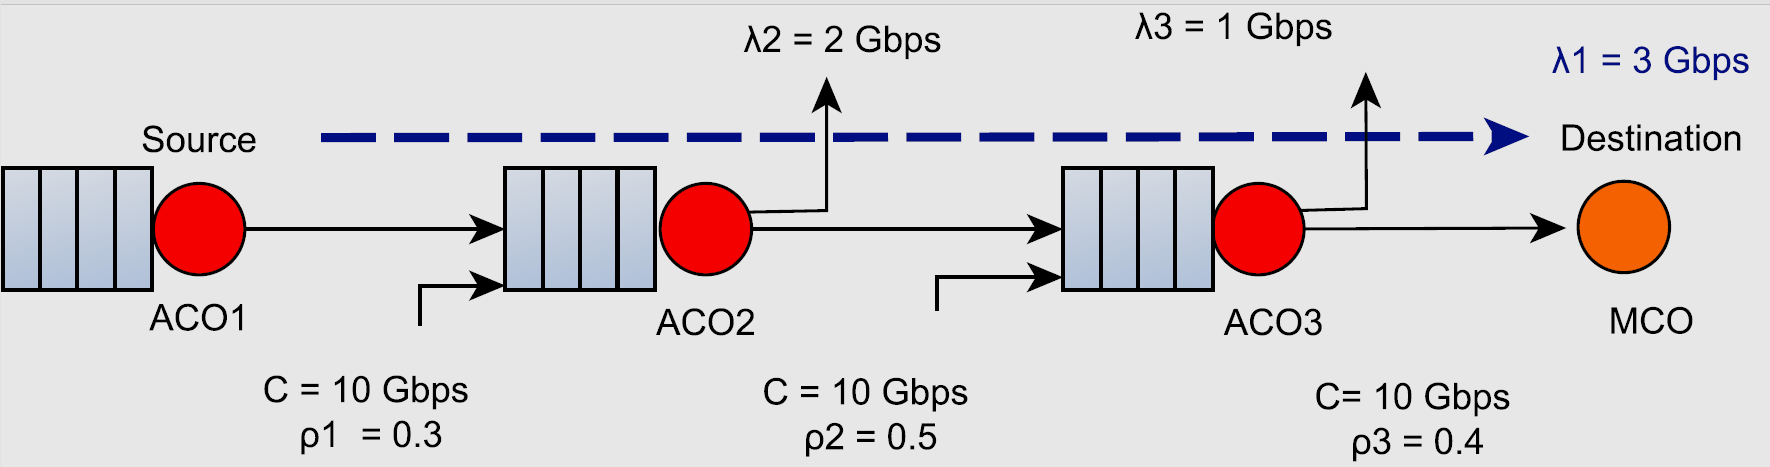

#Functions

### Vysochanskij–Petunin's bound calculation function
Inputs:
- **delay_hops**: Vector of delay at each hop
- **a**: Upper bound percentile from 0 to 1

Output:
- Vysochanskij–Petunin's upper bound


In [17]:
func_bounds_VP <- function(delay_hops, a)
{
  mu = sum(delay_hops)
  sigma = sqrt(sum(delay_hops^2))
  k <- sqrt(4/9/(1-a))
  Prop_VP <- 1 - 4/9/(k^2)
  upper_bound_VP <- k * sigma + mu
  return(upper_bound_VP)
}

#Input data

The **average packet size** is taken from: Amsterdam Internet Exchange Ethernet Frame Size Distribution, statistics available online at https://stats.ams-ix.net/sflow/size.html, accessed on July 2023

Packet sizes in Bytes: 64-127, 128-511, 512 - 1023, 1024 - 1513, 1514, more than 1515.


With their probabilities: 0.332, 0.054, 0.033, 0.037, 0.346, 0.146, 0.052

In [7]:
PS_size=c((64+127)/2,(128+255)/2,(256+511)/2, (512+1023)/2, (1024+1513)/2, 1514, (1515+9100)/2)
PS_weights=c(33.2/100, 5.4/100, 3.3/100, 3.7/100, 34.6/100, 14.6/100, 5.2/100)
N = sum(PS_size*PS_weights)
N
var_N <- sum(PS_size^2*PS_weights) - N^2
Cs2 <- var_N/(N^2)

Capacity_Gbps = 10
Capacity_bps = 10*1e9
load = c(0.3,0.5,0.4)

[1] 1019.035

## M/M/1

### Theoretical calculations
The mean delay $E(D)$ is given by:
$E(D) = E(X) \frac{1}{1-\rho} = \frac{1}{\mu -\lambda} = Sd(D)$

In [8]:
N = 1019.035
Capacity_ps = Capacity_Gbps * 1e9/(8*N)
mu = 1/Capacity_ps
traffic_ps = Capacity_ps*load
theor_delay_link_mm1 = 1/(Capacity_ps*(1-load))
cat("Theoretical M/M/1 delays:", theor_delay_link_mm1, "\n")

Theoretical M/M/1 delays 1.164611e-06 1.630456e-06 1.358713e-06 


### Simmer simulation

In [12]:
env <- simmer("SuperDuperSim") #creating the simmer environment

env %>% add_resource('node_1') %>%#, queue_size = 100) %>%
  add_resource('node_2') %>%
  add_resource('node_3')

traffic_1_4_ <- trajectory() %>%
  seize("node_1") %>%
  timeout( function() rexp(1, Capacity_ps)) %>%
  release("node_1") %>%
  seize("node_2") %>%
  timeout( function() rexp(1, Capacity_ps)) %>%
  release("node_2") %>%
  seize("node_3") %>%
  timeout(function() rexp(1, Capacity_ps)) %>%
  release("node_3")

traffic_2_3_ <- trajectory() %>%
  seize("node_2") %>%
  timeout( function() rexp(1, Capacity_ps)) %>%
  release("node_2")

traffic_3_4_ <- trajectory() %>%
  seize("node_3") %>%
  timeout( function() rexp(1, Capacity_ps)) %>%
  release("node_3")



env %>%
  add_generator("traffic_1_4_", traffic_1_4_, function() rexp(1, traffic_ps[1]))%>%
  add_generator("traffic_2_3_", traffic_2_3_, function() rexp(1, traffic_ps[2] - traffic_ps[1]))%>%
  add_generator("traffic_3_4_", traffic_3_4_, function() rexp(1, traffic_ps[3] - traffic_ps[1]))

env %>% #env execution
  run(10000/min(traffic_ps))


all_arrivals_res <- data.frame(env %>%
                                 get_mon_arrivals(per_resource = TRUE) %>%
                                 transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                 transform(spending_time = end_time - start_time))

for (node in 1:3){
  traffic <- dplyr::filter(all_arrivals_res, paste0("node_", node) == all_arrivals_res$resource)
  print(paste("Node - ", node, ":"))
  print(paste("simmer E(T) =", mean(traffic$spending_time), "s"))
  #C_a <- sd(diff(df_arr_times_f1$time))/mean(diff(df_arr_times_f1$time))
  #C_s <- sd(df_arr_times_f1$timeout1)/mean(df_arr_times_f1$timeout1)
  print(paste("Kingman theor E(T) = ", theor_delay_link_mm1[node], "s"))
}


all_arrivals_res <- data.frame(env %>%
                                 get_mon_arrivals(per_resource = FALSE) %>%
                                 transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                 transform(spending_time = end_time - start_time))

traffic <- dplyr::filter(all_arrivals_res, grepl("traffic_1_4_", all_arrivals_res$name))

print(mean(traffic$spending_time))

delay_sim_mm1 <- traffic$spending_time

upper_bound_mm1_p99 <- func_bounds_VP(theor_delay_link_mm1, 0.99)
upper_bound_mm1_p90 <- func_bounds_VP(theor_delay_link_mm1, 0.9)



simmer environment: SuperDuperSim | now: 0 | next: 
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }

simmer environment: SuperDuperSim | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Source: traffic_1_4_ | monitored: 1 | n_generated: 0 }
{ Source: traffic_2_3_ | monitored: 1 | n_generated: 0 }
{ Source: traffic_3_4_ | monitored: 1 | n_generated: 0 }

simmer environment: SuperDuperSim | now: 0.0271742666666667 | next: 0.0271745064812623
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 1(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 1(1) | queue status: 0(Inf) }
{ Source: traffic_1_4_ | monitored: 1 | n_generated: 9921 }
{ Source: traffic_2_3_ | monitored: 1 | n_generated: 6733 }
{ Source: traffic_3_4_ | monitored: 1 | n_generated: 3392 }

[1] "Node -  1 :"
[1] "simmer E(T) = 1.13144350112267e-06 s"
[1] "Kingman theor E(T) =  1.16461142857143e-06 s"
[1] "Node -  2 :"
[1] "simmer E(T) = 1.67751756504682e-06 s"
[1] "Kingman theor E(T) =  1.630456e-06 s"
[1] "Node -  3 :"
[1] "simmer E(T) = 1.39373095493267e-06 s"
[1] "Kingman theor E(T) =  1.35871333333333e-06 s"
[1] 4.19577e-06


## M/G/1

### Theoretical calculations

the mean delay $E(D)$ is given by: $E(D) \approx E(X) \frac{\rho}{1-\rho}\frac{1+C_X^2}{2} + E(X)$

In [13]:
PS_size=c((64+127)/2,(128+255)/2,(256+511)/2, (512+1023)/2, (1024+1513)/2, 1514, (1515+9100)/2)
PS_weights=c(33.2/100, 5.4/100, 3.3/100, 3.7/100, 34.6/100, 14.6/100, 5.2/100)
N = sum(PS_size*PS_weights)
N

Capacity_ps = Capacity_Gbps * 1e9/(8*N)
traffic_ps = Capacity_ps*load
mu = 1/Capacity_ps

var_N <- sum(PS_size^2*PS_weights) - N^2
Cs2 <- var_N/(N^2)

theor_delay_link_mg1 <- mu * load/(1-load) * (1 + Cs2)/2 + mu
cat("Theoretical M/G/1 delays:", theor_delay_link_mg1, "\n")

[1] 1019.035

Theoretical M/G/1 delays 1.216932e-06 1.752538e-06 1.440102e-06 


### Simmer simulation

In [14]:
env <- simmer("SuperDuperSim") #creating the simmer environment
set.seed(42)

env %>% add_resource('node_1') %>%#, queue_size = 100) %>%
  add_resource('node_2') %>%
  add_resource('node_3')

traffic_1_4_ <- trajectory() %>%
  seize("node_1") %>%
  timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(Capacity_bps)) %>%
  release("node_1") %>%
  seize("node_2") %>%
  timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(Capacity_bps)) %>%
  release("node_2") %>%
  seize("node_3") %>%
  timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(Capacity_bps)) %>%
  release("node_3")

traffic_2_3_ <- trajectory() %>%
  seize("node_2") %>%
  timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(Capacity_bps)) %>%
  release("node_2")

traffic_3_4_ <- trajectory() %>%
  seize("node_3") %>%
  timeout(function() 8*sample(PS_size,size = 1, replace = T, prob = PS_weights)/(Capacity_bps)) %>%
  release("node_3")

env %>%
  add_generator("traffic_1_4_", traffic_1_4_, function() rexp(1, traffic_ps[1])) %>%
  add_generator("traffic_2_3_", traffic_2_3_, function() rexp(1, traffic_ps[2] - traffic_ps[1])) %>%
  add_generator("traffic_3_4_", traffic_3_4_, function() rexp(1, traffic_ps[3] - traffic_ps[1]))

env %>% #env execution
  run(10000/min(traffic_ps))


all_arrivals_res <- data.frame(env %>%
                                 get_mon_arrivals(per_resource = TRUE) %>%
                                 transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                 transform(spending_time = end_time - start_time))

for (node in 1:3){
  traffic <- dplyr::filter(all_arrivals_res, paste0("node_", node) == all_arrivals_res$resource)
  print(paste("Node - ", node, ":"))
  print(paste("simmer E(T) =", mean(traffic$spending_time), "s"))
  print(paste("Kingman theor E(T) = ", theor_delay_link_mg1[node], "s"))
}


all_arrivals_res <- data.frame(env %>%
                                 get_mon_arrivals(per_resource = FALSE) %>%
                                 transform(waiting_time_in_queue = round(end_time - start_time - activity_time)) %>%
                                 transform(spending_time = end_time - start_time))

traffic <- dplyr::filter(all_arrivals_res, grepl("traffic_1_4_", all_arrivals_res$name))

print(mean(traffic$spending_time))
print(sum(theor_delay_link_mg1))
delay_sim_mg1 <- traffic$spending_time

upper_bound_mg1_p99 <- func_bounds_VP(theor_delay_link_mg1, 0.99)
upper_bound_mg1_p90 <- func_bounds_VP(theor_delay_link_mg1, 0.9)

simmer environment: SuperDuperSim | now: 0 | next: 
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }

simmer environment: SuperDuperSim | now: 0 | next: 0
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Source: traffic_1_4_ | monitored: 1 | n_generated: 0 }
{ Source: traffic_2_3_ | monitored: 1 | n_generated: 0 }
{ Source: traffic_3_4_ | monitored: 1 | n_generated: 0 }

simmer environment: SuperDuperSim | now: 0.0271742666666667 | next: 0.0271744031620108
{ Monitor: in memory }
{ Resource: node_1 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_2 | monitored: TRUE | server status: 0(1) | queue status: 0(Inf) }
{ Resource: node_3 | monitored: TRUE | server status: 1(1) | queue status: 2(Inf) }
{ Source: traffic_1_4_ | monitored: 1 | n_generated: 10058 }
{ Source: traffic_2_3_ | monitored: 1 | n_generated: 6533 }
{ Source: traffic_3_4_ | monitored: 1 | n_generated: 3316 }

[1] "Node -  1 :"
[1] "simmer E(T) = 1.21109712188637e-06 s"
[1] "Kingman theor E(T) =  1.21693243877927e-06 s"
[1] "Node -  2 :"
[1] "simmer E(T) = 1.80066718582965e-06 s"
[1] "Kingman theor E(T) =  1.75253835715162e-06 s"
[1] "Node -  3 :"
[1] "simmer E(T) = 1.49156690569984e-06 s"
[1] "Kingman theor E(T) =  1.44010157143441e-06 s"
[1] 4.47715e-06
[1] 4.409572e-06


## PDF plots

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


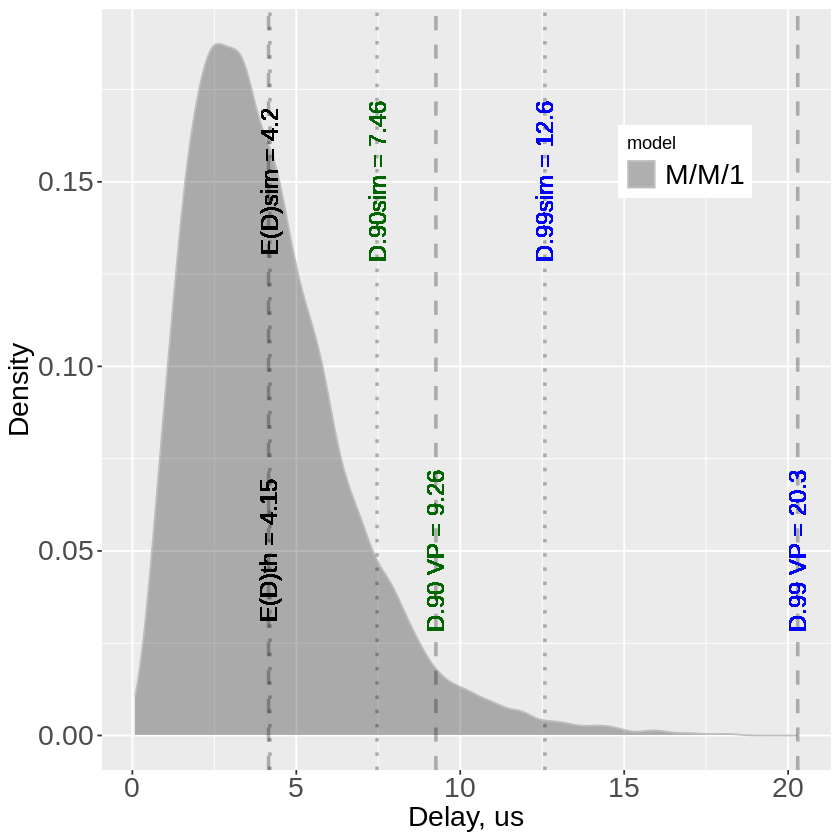

In [15]:
model_colors <- c("M/M/1" = "gray")
model_alpha <- c("M/M/1" = 0.5)

df <- data.frame(model = c(rep("M/M/1",length(delay_sim_mm1))),
                 delay = c(delay_sim_mm1))
df$delay <- df$delay*1e6# + sum(E(g)$Prop_Delay)*1e6

#df$model <- factor(df$model, levels = c("M/M/1"))

text_size=5
size = 17
plot1 <-ggplot(data = df, aes(x=delay, group=model, fill = model)) +
  geom_density( alpha = 0.3, colour = model_colors) +
  scale_fill_manual(values = "gray8") +  # Set custom colors
  theme_gray() +
  xlab("Delay, us") +
  ylab("Density") +
  #xlim(0, 40) +
  theme(#legend.title =  element_blank(),
        legend.text = element_text(size=size),
        legend.position = c(0.8, 0.8),
        axis.title.x = element_text(size=size),
        axis.title.y = element_text(size=size),
        axis.text = element_text(size=size),
        axis.text.x = element_text(size = size),  # Adjust x-axis text size
        axis.text.y = element_text(size = size)) +  # Adjust y-axis text size)
  #E(D)th
  geom_vline(xintercept = sum(theor_delay_link_mm1)*1e6, linetype = 2, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = sum(theor_delay_link_mm1)*1e6, y = 0.05, label = paste("E(D)th =", signif(sum(theor_delay_link_mm1)*1e6, digits = 3))),
            angle = 90, color = "black", hjust = 0.5, vjust = 0.5, size = text_size) +
  #E(D)sim
  geom_vline(xintercept = mean(delay_sim_mm1)*1e6, linetype = 3, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = mean(delay_sim_mm1)*1e6, y = 0.15, label = paste("E(D)sim =", signif(mean(delay_sim_mm1)*1e6, digits = 3))),
            angle = 90, color = "black", hjust = 0.5, vjust = 0.5, size = text_size) +
  #D99 sim
  geom_vline(xintercept = quantile(delay_sim_mm1*1e6, p = 0.99), linetype = 3, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = quantile(delay_sim_mm1*1e6, p = 0.99), y = 0.15, label = paste("D.99sim =", signif(quantile(delay_sim_mm1*1e6, p = 0.99), digits = 3))),
            angle = 90, color = "blue", hjust = 0.5, vjust = 0.5, size = text_size) +
  #D99 upper bound
  geom_vline(xintercept = upper_bound_mm1_p99 *1e6, linetype = 2, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = upper_bound_mm1_p99 *1e6, y = 0.05, label = paste("D.99 VP =", signif(upper_bound_mm1_p99*1e6, digits = 3))),
            angle = 90, color = "blue", hjust = 0.5, vjust = 0.5, size = text_size) +
  #D99 sim
  geom_vline(xintercept = quantile(delay_sim_mm1*1e6, p = 0.9), linetype = 3, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = quantile(delay_sim_mm1*1e6, p = 0.9), y = 0.15, label = paste("D.90sim =", signif(quantile(delay_sim_mm1*1e6, p = 0.9), digits = 3))),
            angle = 90, color = "darkgreen", hjust = 0.5, vjust = 0.5, size = text_size) +
  #D99 upper bound
  geom_vline(xintercept = upper_bound_mm1_p90 *1e6, linetype = 2, color = "gray8", size = 1, alpha = 0.3) +
  geom_text(aes(x = upper_bound_mm1_p90 *1e6, y = 0.05, label = paste("D.90 VP =", signif(upper_bound_mm1_p90*1e6, digits = 3))),
            angle = 90, color = "darkgreen", hjust = 0.5, vjust = 0.5, size = text_size)

plot1

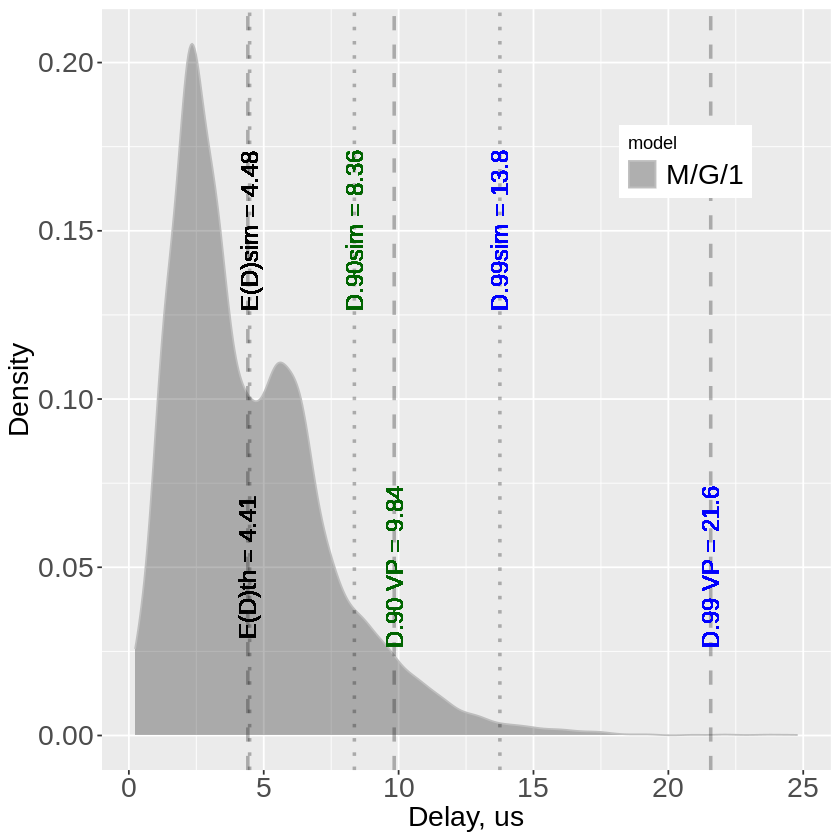

In [19]:

model_colors <- c("M/G/1" = "gray")
model_alpha <- c("M/G/1" = 0.5)

df <- data.frame(model = c(rep("M/G/1",length(delay_sim_mg1))),
                 delay = c(delay_sim_mg1))
df$delay <- df$delay*1e6


color = "gray8"
plot2 <- ggplot(data = df, aes(x=delay, group=model, fill = model)) +
  geom_density( alpha = 0.3, colour = model_colors) +
  scale_fill_manual(values = color) +  # Set custom colors
  theme_gray() +
  xlab("Delay, us") +
  ylab("Density") +
  #xlim(0, 40) +
  theme(#legend.title =  element_blank(),
    legend.text = element_text(size=size),
    legend.position = c(0.8, 0.8),
    axis.title.x = element_text(size=size),
    axis.title.y = element_text(size=size),
    axis.text = element_text(size=size),
    axis.text.x = element_text(size = size),  # Adjust x-axis text size
    axis.text.y = element_text(size = size)  # Adjust y-axis text size
    ) +
  #E(D)th
  geom_vline(xintercept = sum(theor_delay_link_mg1)*1e6, linetype = 2, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = sum(theor_delay_link_mg1)*1e6, y = 0.05, label = paste("E(D)th =", signif(sum(theor_delay_link_mg1)*1e6, digits = 3))),
            angle = 90, color = "black", hjust = 0.5, vjust = 0.5, size = text_size) +
  #E(D)sim
  geom_vline(xintercept = mean(delay_sim_mg1)*1e6, linetype = 3, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = mean(delay_sim_mg1)*1e6, y = 0.15, label = paste("E(D)sim =", signif(mean(delay_sim_mg1)*1e6, digits = 3))),
            angle = 90, color = "black", hjust = 0.5, vjust = 0.5,  size = text_size) +
  #D99 sim
  geom_vline(xintercept = quantile(delay_sim_mg1*1e6, p = 0.99), linetype = 3, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = quantile(delay_sim_mg1*1e6, p = 0.99), y = 0.15, label = paste("D.99sim =", signif(quantile(delay_sim_mg1*1e6, p = 0.99), digits = 3))),
            angle = 90, color = "blue", hjust = 0.5, vjust = 0.5,  size = text_size) +
  #D99 upper bound
  geom_vline(xintercept = upper_bound_mg1_p99*1e6, linetype = 2, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = upper_bound_mg1_p99 *1e6, y = 0.05, label = paste("D.99 VP =", signif(upper_bound_mg1_p99*1e6, digits = 3))),
            angle = 90, color = "blue", hjust = 0.5, vjust = 0.5, size = text_size) +
  #D99 sim
  geom_vline(xintercept = quantile(delay_sim_mg1*1e6, p = 0.9), linetype = 3, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = quantile(delay_sim_mg1*1e6, p = 0.9), y = 0.15, label = paste("D.90sim =", signif(quantile(delay_sim_mg1*1e6, p = 0.9), digits = 3))),
            angle = 90, color = "darkgreen", hjust = 0.5, vjust = 0.5,  size = text_size) +
  #D99 upper bound
  geom_vline(xintercept = upper_bound_mg1_p90 *1e6, linetype = 2, color = color, size = 1, alpha = 0.3) +
  geom_text(aes(x = upper_bound_mg1_p90 *1e6, y = 0.05, label = paste("D.90 VP =", signif(upper_bound_mg1_p90*1e6, digits = 3))),
            angle = 90, color = "darkgreen", hjust = 0.5, vjust = 0.5, size = text_size)

plot2